In [1038]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from prophet import Prophet
import statsmodels.api as sm
import itertools
from tqdm import tqdm
import pickle
from scipy.interpolate import UnivariateSpline

In [141]:
dfo = pd.read_csv('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/AEP_hourly.csv')

In [143]:
dfo['Datetime'] = pd.to_datetime(dfo['Datetime'])
#df.set_index('Datetime', inplace = True)
#df.sort_index(inplace = True)

In [145]:
df = dfo.groupby(pd.Grouper(key='Datetime', axis=0, freq='W')).sum()

In [147]:
df.sort_index(inplace = True)

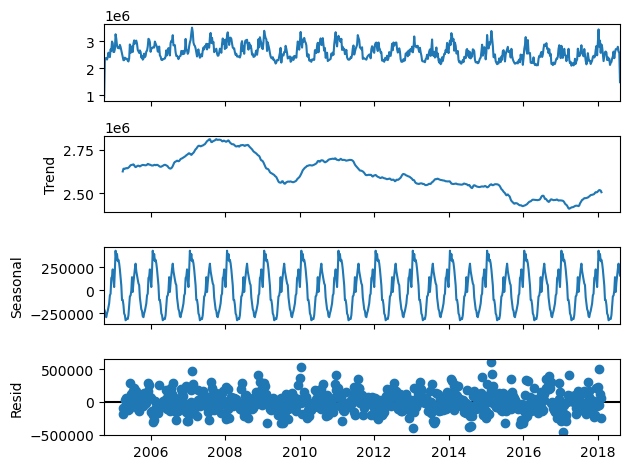

In [291]:
decomp_a = seasonal_decompose(df, model = 'additive', period = 52)
decomp_a.plot()
plt.show()

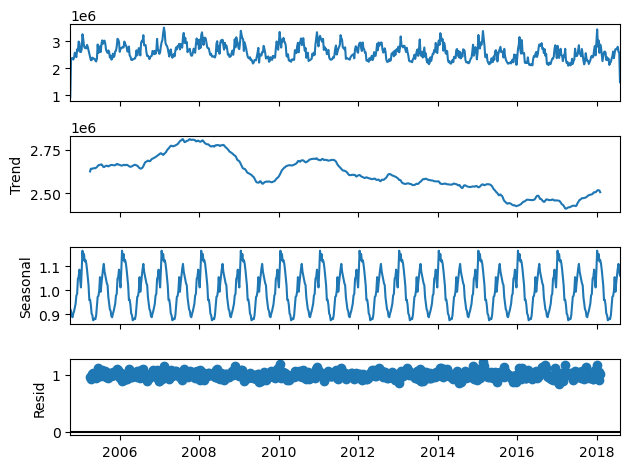

In [293]:
decomp_b = seasonal_decompose(df, model = 'multiplicative', period = 52)
decomp_b.plot()
plt.show()

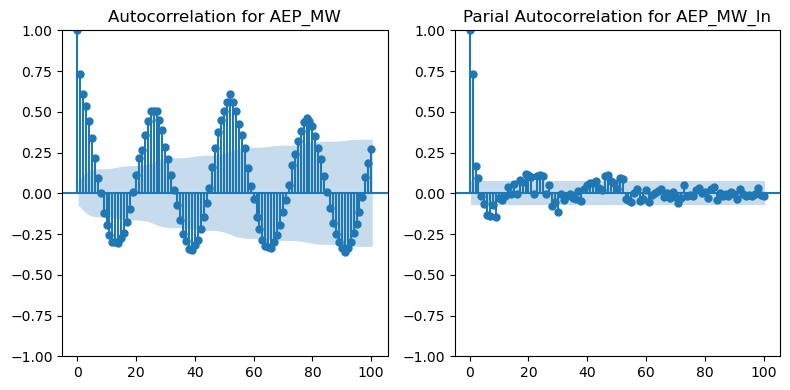

In [287]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_acf(df, lags=100, ax=axes[0])
axes[0].set_title("Autocorrelation for AEP_MW")

plot_pacf(df, lags=100, ax=axes[1])
axes[1].set_title("Parial Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

In [156]:
dfm = df.copy()

In [161]:
dfm['AEP_MW_ln'] = np.log(dfm['AEP_MW'])

In [163]:
dfd = dfm.diff(1).diff(52)

In [165]:
dfd = dfd.dropna()

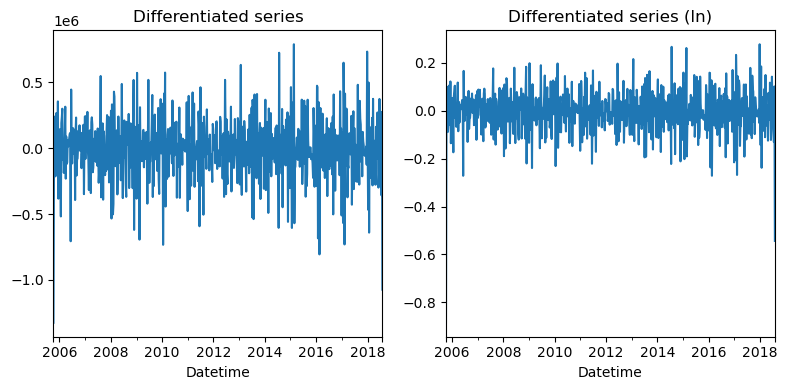

In [300]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

dfd['AEP_MW'].plot(ax=axes[0]) 
axes[0].set_title("Differentiated series")

dfd['AEP_MW_ln'].plot(ax=axes[1])
axes[1].set_title("Differentiated series (ln)")

plt.tight_layout()
plt.show()

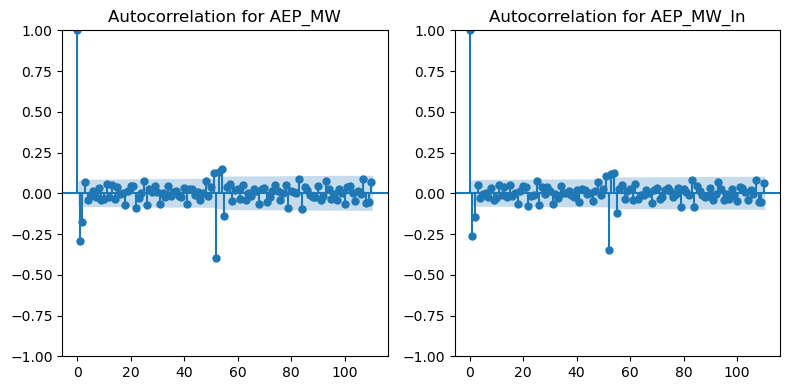

In [279]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_acf(dfd['AEP_MW'], lags=110, ax=axes[0])
axes[0].set_title("Autocorrelation for AEP_MW")

plot_acf(dfd['AEP_MW_ln'], lags=110, ax=axes[1])
axes[1].set_title("Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

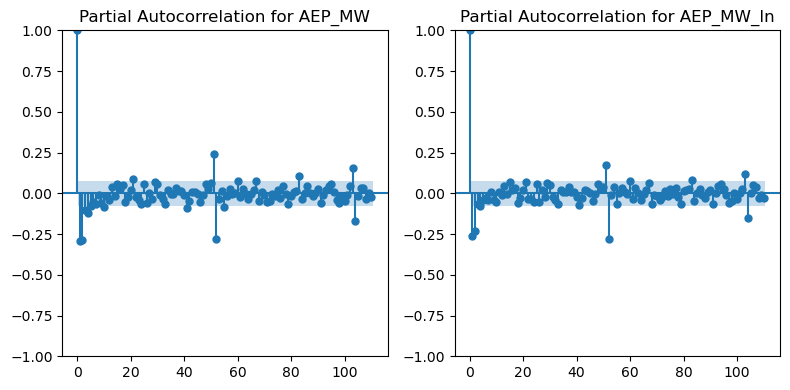

In [281]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_pacf(dfd['AEP_MW'], lags=110, ax=axes[0])
axes[0].set_title("Partial Autocorrelation for AEP_MW")

plot_pacf(dfd['AEP_MW_ln'], lags=110, ax=axes[1])
axes[1].set_title("Partial Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

In [179]:
adt1, adt2 = adfuller(dfd['AEP_MW']), adfuller(dfd['AEP_MW_ln'])
print(f"p-value szeregu {adt1[1]}, p-value szeregu ln {adt2[1]}")

p-value szeregu 3.6978756890071637e-23, p-value szeregu ln 1.8725339365726934e-22


In [197]:
combinations = list(itertools.product([0, 1, 2], repeat=4))
matrix = np.array(combinations)
dfL = pd.DataFrame(matrix, columns = ['p', 'q', 'P', 'Q'])
dfL.drop(0, inplace = True)
dfL['AIC'] = 0
dfL['BIC'] = 0

dfL2 = dfL.copy()

In [199]:
data_train = dfm.loc['2005-01-01':'2017-12-31', :]
data_test = dfm.loc['2018-01-01':'2018-06-30', :]

In [201]:
for i in tqdm(dfL.index, desc="Przetwarzanie SARIMA dla dfL"):
    model = SARIMAX(data_train['AEP_MW'], order = (dfL.loc[i, 'p'], 1, dfL.loc[i, 'q']), seasonal_order = (dfL.loc[i, 'P'], 1, dfL.loc[i, 'Q'], 52))
    model = model.fit()
    dfL.loc[i, 'AIC'] = model.aic
    dfL.loc[i, 'BIC'] = model.bic
for i in tqdm(dfL2.index, desc="Przetwarzanie SARIMA dla dfL"):
    model = SARIMAX(data_train['AEP_MW_ln'], order = (dfL2.loc[i, 'p'], 1, dfL2.loc[i, 'q']), seasonal_order = (dfL2.loc[i, 'P'], 1, dfL2.loc[i, 'Q'], 52))
    model = model.fit()
    dfL2.loc[i, 'AIC'] = model.aic
    dfL2.loc[i, 'BIC'] = model.bic

Przetwarzanie SARIMA dla dfL:   5%|██▋                                                  | 4/80 [00:42<13:01, 10.29s/it]C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Przetwarzanie SARIMA dla dfL:   9%|████▋                                                | 7/80 [02:14<27:21, 22.49s/it]C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Przetwarzanie SARIMA dla dfL:  16%|████████▍                                           | 13/80 [04:54<23:06, 20.69s/it]C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Like

In [257]:
df_IC = pd.concat([dfL.loc[[dfL['AIC'].idxmin()]], dfL.loc[[dfL['BIC'].idxmin()]], dfL.loc[[dfL2['AIC'].idxmin()]], dfL.loc[[dfL2['AIC'].idxmin()]]])

In [267]:
df_IC.reset_index(drop = True, inplace= True)

In [360]:
models = []
for i in range(3):
    if i < 2:
        model = SARIMAX(data_train['AEP_MW'], order = (df_IC.loc[i, 'p'], 1, df_IC.loc[i, 'q']), seasonal_order = (df_IC.loc[i, 'P'], 1, df_IC.loc[i, 'Q'], 52))
    else:
        model = SARIMAX(np.log(data_train['AEP_MW']), order = (df_IC.loc[i, 'p'], 1, df_IC.loc[i, 'q']), seasonal_order = (df_IC.loc[i, 'P'], 1, df_IC.loc[i, 'Q'], 52))
    models.append(model.fit())

Model nr 0


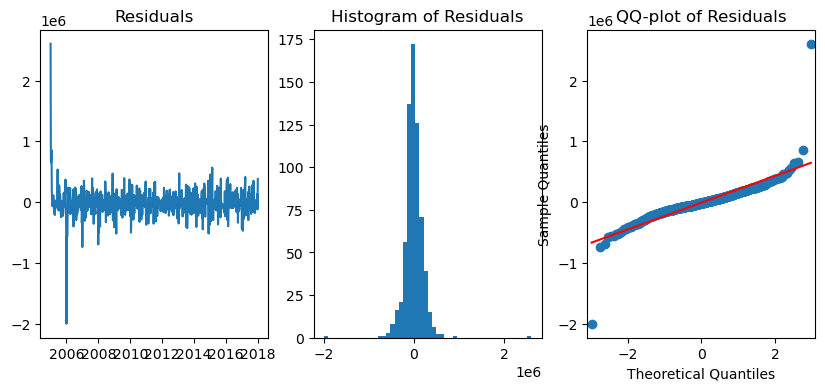

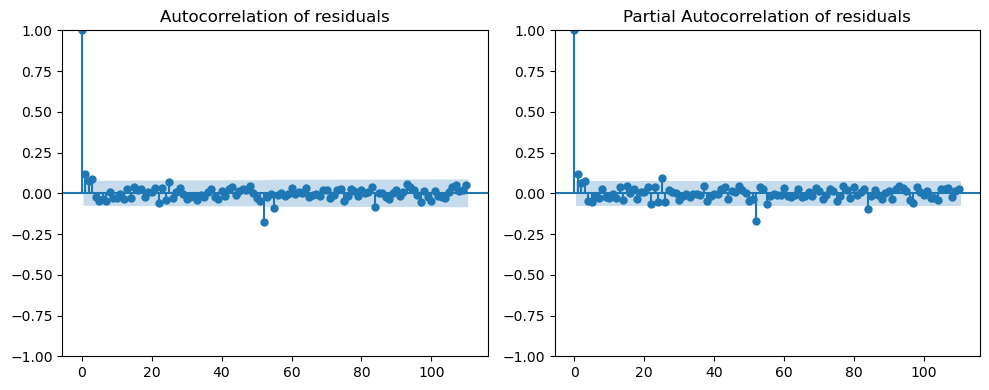

Model nr 1


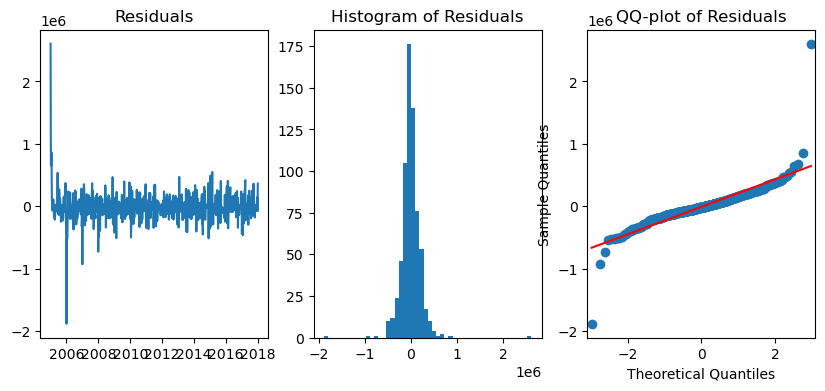

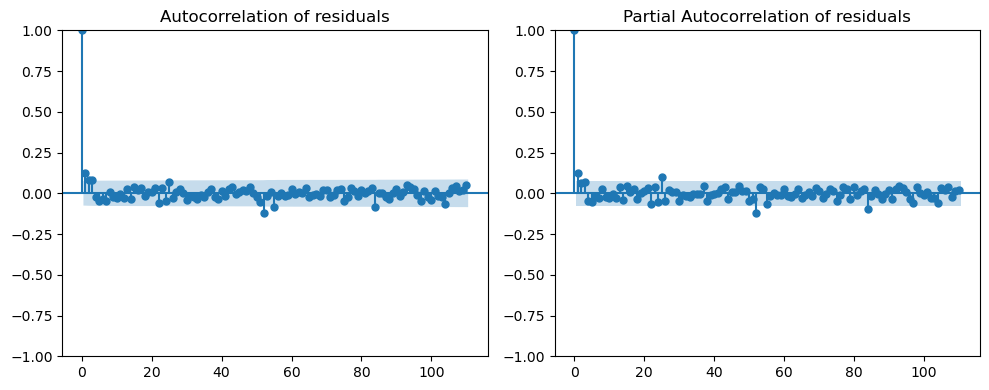

Model nr 2


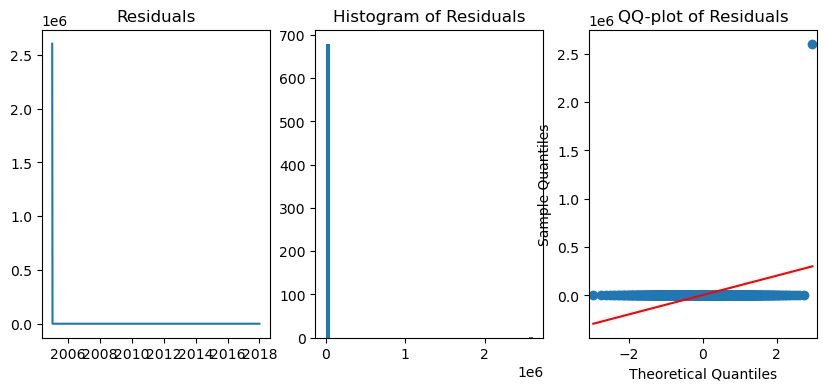

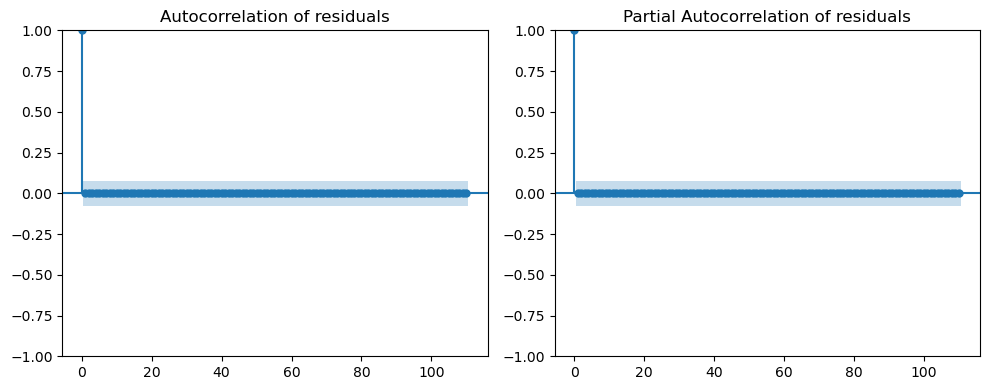

In [361]:
for i in range(3):

    print(f'Model nr {i}')
    model_fit = models[i]

    if i < 2:
        resid = model_fit.resid
    else: 
        resid = np.exp(model_fit.resid)

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    axes[0].plot(resid)
    axes[0].set_title("Residuals")

    axes[1].hist(resid, bins=50)
    axes[1].set_title("Histogram of Residuals")

    sm.qqplot(resid, line='s', ax=axes[2])
    axes[2].set_title("QQ-plot of Residuals")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    plot_acf(resid, lags=110, ax=axes[0])
    axes[0].set_title("Autocorrelation of residuals")

    plot_pacf(resid, lags=110, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation of residuals")

    plt.tight_layout()
    plt.show()

In [622]:
df_pred = data_test[['AEP_MW']].copy()

In [624]:
for i in range(3):
    
    #print(f'Model nr {i}')
    model_fit = models[i]
    pred = model_fit.predict(start = '2018-01-07', end = '2018-06-24')
    if i < 2:
        df_pred[f'Pred no {i}'] = pred
    else:
        df_pred[f'Pred no {i}'] = np.exp(pred)

In [530]:
###prophet

In [536]:
dfp1 = data_train[['AEP_MW']].copy()
dfp2 = data_train[['AEP_MW_ln']].copy()

In [543]:
dfp1.reset_index(inplace = True)
dfp2.reset_index(inplace = True)

In [545]:
dfp1.columns = ['ds', 'y']
dfp2.columns = ['ds', 'y']

In [572]:
modelp1 = Prophet(yearly_seasonality = False, weekly_seasonality = False, daily_seasonality = False)
modelp2 = Prophet(yearly_seasonality = False, weekly_seasonality = False, daily_seasonality = False)

In [574]:
modelp1.add_seasonality(name='yearly', period=52, fourier_order=10)
modelp1.add_seasonality(name='weekly', period=1, fourier_order=10)

modelp2.add_seasonality(name='yearly', period=52, fourier_order=10)
modelp2.add_seasonality(name='weekly', period=1, fourier_order=10)

In [576]:
modelp_fit1 = modelp1.fit(dfp1)
modelp_fit2 = modelp2.fit(dfp2)

16:57:36 - cmdstanpy - INFO - Chain [1] start processing
16:57:36 - cmdstanpy - INFO - Chain [1] done processing
16:57:36 - cmdstanpy - INFO - Chain [1] start processing
16:57:36 - cmdstanpy - INFO - Chain [1] done processing


In [586]:
future = modelp_fit1.make_future_dataframe(periods=25, freq = 'W')

In [593]:
predp1 = modelp_fit1.predict(future)[['ds', 'yhat']]
predp2 = modelp_fit2.predict(future)[['ds', 'yhat']]

In [ ]:
df_pred = df_pred.merge(predp1.set_index('ds'), left_index = True, right_index = True)
df_pred.rename({'yhat':'Pred no 3'}, axis =1, inplace = True)

In [649]:
df_pred = df_pred.merge(predp2.set_index('ds'), left_index = True, right_index = True)
df_pred.rename({'yhat':'Pred no 4'}, axis =1, inplace = True)

In [657]:
df_pred['Pred no 4'] = np.exp(df_pred['Pred no 4'])

In [675]:
## trend + sezonowosc 

In [1202]:
df_ts = data_train.copy()

In [1204]:
df_ts[['Trend', 'Trend ln']] = df_ts.rolling(window = 13).mean().values

In [1206]:
df_ts['Detrend'] = df_ts['AEP_MW'] - df_ts['Trend']
df_ts['Detrend ln'] = df_ts['AEP_MW_ln'] - df_ts['Trend ln']

In [1208]:
df_ts = df_ts.loc[df_ts['Trend'].notna(), :]
df_ts = df_ts.loc[df_ts.index.year > 2004]

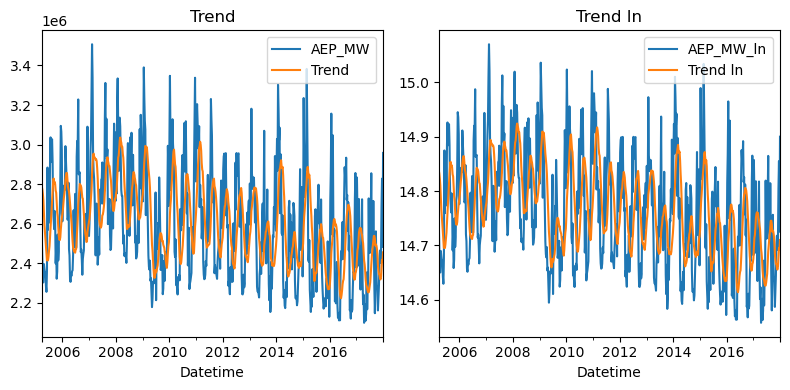

In [1210]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

df_ts.loc[:, df_ts.columns[[0, 2]]].plot(ax=axes[0])
axes[0].set_title("Trend")

df_ts.loc[:, df_ts.columns[[1, 3]]].plot(ax=axes[1])
axes[1].set_title("Trend ln")

plt.tight_layout()
plt.show()

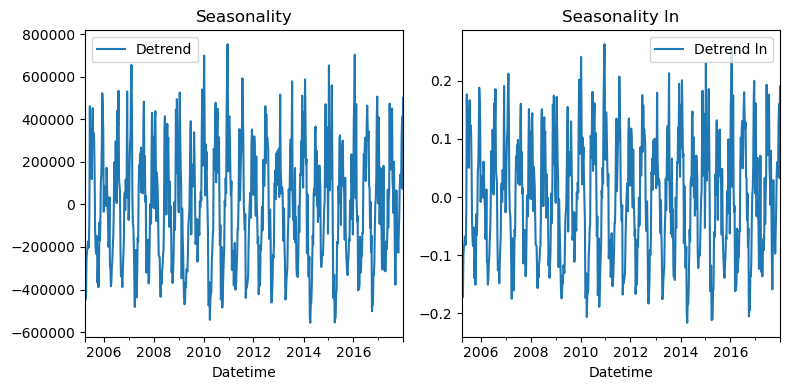

In [1212]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

df_ts.loc[:, df_ts.columns[[4]]].plot(ax=axes[0])
axes[0].set_title("Seasonality")

df_ts.loc[:, df_ts.columns[[5]]].plot(ax=axes[1])
axes[1].set_title("Seasonality ln")

plt.tight_layout()
plt.show()

In [1214]:
df_ts['Week no'] = np.nan
curr_year = df_ts.index[0].year
i = 1
for j in df_ts.index:
    #print(j)
    next_year = j.year
    if curr_year < next_year:
        i = 1
        df_ts.loc[j, 'Week no'] = i
        curr_year = next_year
    else:
        df_ts.loc[j, 'Week no'] = i
        i = i + 1

In [1216]:
df_ts = df_ts.reset_index().merge(df_ts[['Week no', 'Detrend', 'Detrend ln']].reset_index(drop = True).groupby('Week no').mean().rename({'Detrend':'Seasonality', 'Detrend ln':'Seasonality ln'}, axis = 1), left_on = 'Week no', right_on = 'Week no')

In [1218]:
df_ts = df_ts.set_index('Datetime').sort_index()

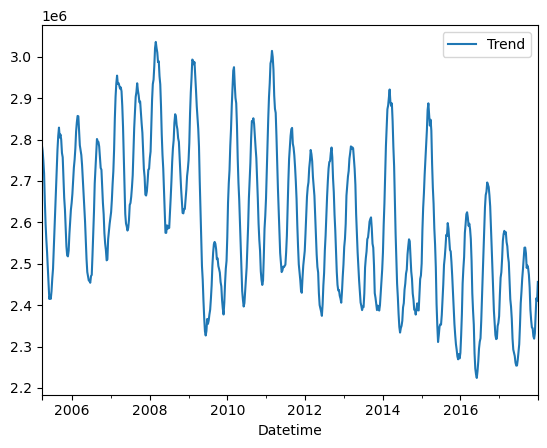

In [1314]:
df_ts[['Trend']].plot()
plt.show()

In [1222]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [1289]:
vals_x = np.arange(len(df_ts))
vals_y = df_ts[['Trend']].values

In [1303]:
poly = PolynomialFeatures(degree=3)
vals_x_poly = poly.fit_transform(vals_x.reshape(-1, 1))

In [1305]:
model_poly = LinearRegression().fit(vals_x_poly, vals_y)

In [692]:
# df_pred.plot()
# plt.show()

In [661]:
for i in range(1,6):
    err = df_pred['AEP_MW'] - df_pred[df_pred.columns[i]]
    df_pred[f'Err no {i}'] = err
df_err = pd.DataFrame(index = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'],columns = ['LP2', 'LP3', 'ALP2', 'ALP3'])

In [665]:
LP2 = ((df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5']]**2).sum(axis = 0))**(1/2)
LP3 = (np.abs(df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5']]**3).sum(axis = 0))**(1/3)
ALP2 = (((df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5']]*np.where(df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5']] < 0, 1.1, 0.9))**2).sum(axis = 0))**(1/2)
ALP3 = (np.abs((df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5']]*np.where(df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5']] < 0, 1.1, 0.9))**3).sum(axis = 0))**(1/3)

In [667]:
df_err.loc[:, 'LP2'] = LP2.values
df_err.loc[:, 'LP3'] = LP3.values
df_err.loc[:, 'ALP2'] = ALP2.values
df_err.loc[:, 'ALP3'] = ALP3.values

In [669]:
df_err

,LP2,LP3,ALP2,ALP3
Model 1,1087033.150815,737583.826561,1179715.177865,802903.583109
Model 2,1154087.609588,784883.127264,1255718.236227,856562.108433
Model 3,864355.296006,577523.643279,846349.463371,569912.805489
Model 4,1566332.835598,1177267.754729,1441882.245526,1068620.241114
Model 5,1626077.463201,1224043.959511,1485905.050124,1107138.135038
